In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from tpot import TPOTClassifier
import matplotlib.pyplot as plt

In [2]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class.parquet")
pd_train["label"] = pd_train["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)

(1241, 16094)


In [3]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class.parquet")
pd_test["label"] = pd_test["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)

(286, 16094)


In [4]:
X_train = pd_train.drop(columns=["Class", "label"])
y_train = pd_train["label"]

X_test = pd_test.drop(columns=["Class", "label"])
y_test = pd_test["label"]

# TPOT optimization

In [5]:
# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=4,  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7492814875999718

Generation 2 - Current best internal CV score: 0.7492814875999718

Generation 3 - Current best internal CV score: 0.7492814875999718

Generation 4 - Current best internal CV score: 0.7492814875999718

Generation 5 - Current best internal CV score: 0.7492814875999718

Best pipeline: RandomForestClassifier(MinMaxScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)


TPOTClassifier(generations=5, n_jobs=4, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [6]:
# Evaluate the best model found by TPOT
y_pred = tpot.predict(X_test)
y_pred_proba = tpot.predict_proba(X_test)[:, 1]

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.8146853146853147
Log Loss: 0.47206500243926136
AUC: 0.88771319178559


# PCA optimization

In [2]:
# # Example data (replace with actual data)
# X = pd.DataFrame(
#     np.random.randn(1000, 1600), columns=[f"feature_{i}" for i in range(1600)]
# )
# y = np.random.randint(2, size=1000)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Dimensions for PCA
# dimensions = [10, 20, 50]
# tpot_results = []  # List to store results

In [5]:
# List to store AUC scores for different PCA dimensions
# dimensions = range(100, 500, 100)  # Check PCA dimensions from 1 to 10
dimensions = [10, 20, 50, 100, 200, 300, 500, 800, 1000, 1200]
# dimensions = [10, 20, 50]
tpot_results = []  # List to store results

# Loop over different numbers of PCA components
for n_components in dimensions:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Set up TPOT with basic configuration
    tpot = TPOTClassifier(
        generations=5,
        population_size=20,
        verbosity=2,
        scoring="roc_auc",  # AUC
        random_state=42,
        n_jobs=12,  # Use 4 cores
    )

    # Fit TPOT on the PCA-transformed data
    tpot.fit(X_train_pca, y_train)

    # Access the best pipeline directly after fitting
    best_pipeline = tpot.fitted_pipeline_

    # Check if the model has predict_proba
    if hasattr(best_pipeline, "predict_proba"):
        y_pred = best_pipeline.predict_proba(X_test_pca)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
    else:
        # Fallback to accuracy if predict_proba is unavailable
        y_pred = best_pipeline.predict(X_test_pca)
        auc = accuracy_score(
            y_test, y_pred
        )  # Substitute with accuracy if AUC can't be calculated

    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Extract model name and parameters
    model_name = type(
        best_pipeline.steps[-1][1]
    ).__name__  # Name of the final estimator
    model_params = best_pipeline.steps[-1][
        1
    ].get_params()  # Params of the final estimator

    # Append results to list
    result = {
        "Best model": best_pipeline,
        "PCA Components": n_components,
        "Model Name": model_name,
        "Parameters": model_params,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    tpot_results.append(result)

    print(result)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7209535364007509

Generation 2 - Current best internal CV score: 0.7209535364007509

Generation 3 - Current best internal CV score: 0.7209535364007509

Generation 4 - Current best internal CV score: 0.7209535364007509

Generation 5 - Current best internal CV score: 0.7307687914137839

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.55, min_samples_leaf=1, min_samples_split=17, n_estimators=100)
{'Best model': Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.55, min_samples_split=17,
                                      random_state=42))]), 'PCA Components': 10, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.55, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7257128292725652

Generation 2 - Current best internal CV score: 0.7257128292725652

Generation 3 - Current best internal CV score: 0.7324240096265375

Generation 4 - Current best internal CV score: 0.7390708986297223

Generation 5 - Current best internal CV score: 0.7396026751349585

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.9500000000000001, min_samples_leaf=1, min_samples_split=14, n_estimators=100)
{'Best model': Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(criterion='entropy',
                                      max_features=0.9500000000000001,
                                      min_samples_split=14, random_state=42))]), 'PCA Components': 20, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.9500000000000001, 'max

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7334913764282592

Generation 2 - Current best internal CV score: 0.7375304498895632

Generation 3 - Current best internal CV score: 0.7375304498895632

Generation 4 - Current best internal CV score: 0.7375304498895632

Generation 5 - Current best internal CV score: 0.7377875678038034

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=6, min_samples_split=9, n_estimators=100)
{'Best model': Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(criterion='entropy',
                                      max_features=0.6500000000000001,
                                      min_samples_leaf=6, min_samples_split=9,
                                      random_state=42))]), 'PCA Components': 50, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'ma

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.723272868898003

Generation 2 - Current best internal CV score: 0.726381723531788

Generation 3 - Current best internal CV score: 0.7279259126712432

Generation 4 - Current best internal CV score: 0.7279259126712432

Generation 5 - Current best internal CV score: 0.7321324337586682

Best pipeline: ExtraTreesClassifier(MinMaxScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=13, n_estimators=100)
{'Best model': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.35000000000000003,
                                      min_samples_leaf=3, min_samples_split=13,
                                      random_state=42))]), 'PCA Components': 100, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', '

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7165919480462337

Generation 2 - Current best internal CV score: 0.7165919480462337

Generation 3 - Current best internal CV score: 0.7165919480462337

Generation 4 - Current best internal CV score: 0.7181313757748118

Generation 5 - Current best internal CV score: 0.7187623518656822

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=4, p=2, weights=distance)
{'Best model': Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))]), 'PCA Components': 200, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8990602158022973, 'Precision': 0.9381443298969072, 'Recall': 0.8235294117647058, 'Sensitivity': 0.8235294117647058, 'Specificity': 0.8153846153846154}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.711734765851004

Generation 2 - Current best internal CV score: 0.711734765851004

Generation 3 - Current best internal CV score: 0.711734765851004

Generation 4 - Current best internal CV score: 0.711734765851004

Generation 5 - Current best internal CV score: 0.711734765851004

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=1, weights=distance)
{'Best model': Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]), 'PCA Components': 300, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, 'AUC': 0.8780368952314652, 'Precision': 0.9306930693069307, 'Recall': 0.8506787330316742, 'Sensitivity': 0.8506787330316742, 'Specificity': 0.7846153846153846}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7164003328817226

Generation 2 - Current best internal CV score: 0.7164003328817226

Generation 3 - Current best internal CV score: 0.7164003328817226

Generation 4 - Current best internal CV score: 0.7164003328817226

Generation 5 - Current best internal CV score: 0.7169865312469434

Best pipeline: KNeighborsClassifier(KNeighborsClassifier(input_matrix, n_neighbors=20, p=2, weights=distance), n_neighbors=3, p=1, weights=distance)
{'Best model': Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=KNeighborsClassifier(n_neighbors=20,
                                                                  weights='distance'))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]), 'PCA Components': 500, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs'

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7171223119722342

Generation 2 - Current best internal CV score: 0.7171223119722342

Generation 3 - Current best internal CV score: 0.7171223119722342

Generation 4 - Current best internal CV score: 0.7171223119722342

Generation 5 - Current best internal CV score: 0.7171223119722342

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)
{'Best model': Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))]), 'PCA Components': 800, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8666202575704838, 'Precision': 0.9361702127659575, 'Recall': 0.7963800904977375, 'Sensitivity': 0.7963800904977375, 'Specificity': 0.8153846153846154}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7120304041793281

Generation 2 - Current best internal CV score: 0.7120304041793281

Generation 3 - Current best internal CV score: 0.7120304041793281

Generation 4 - Current best internal CV score: 0.7138531783792627

Generation 5 - Current best internal CV score: 0.7138531783792627

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=7, p=2, weights=distance)
{'Best model': Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))]), 'PCA Components': 1000, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8990602158022972, 'Precision': 0.9384615384615385, 'Recall': 0.8280542986425339, 'Sensitivity': 0.8280542986425339, 'Specificity': 0.8153846153846154}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7023357969026041

Generation 2 - Current best internal CV score: 0.7147752813519371

Generation 3 - Current best internal CV score: 0.7156608213170849

Generation 4 - Current best internal CV score: 0.7156608213170849

Generation 5 - Current best internal CV score: 0.7156608213170849

Best pipeline: KNeighborsClassifier(GaussianNB(input_matrix), n_neighbors=3, p=2, weights=distance)
{'Best model': Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=GaussianNB())),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))]), 'PCA Components': 1200, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8733727810650888, 'Precision': 0.9368421052631579, 'Recall': 0.8054298642533937, 'Sensitivity': 

In [6]:
# Convert results to DataFrame
tpot_df = pd.DataFrame(tpot_results)
tpot_df

,Best model,PCA Components,Model Name,Parameters,AUC,Precision,Recall,Sensitivity,Specificity
0,"((ExtraTreeClassifier(max_features=0.55, min_s...",10,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.860355,0.911765,0.841629,0.841629,0.723077
1,"((ExtraTreeClassifier(criterion='entropy', max...",20,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.901636,0.930348,0.846154,0.846154,0.784615
2,"((ExtraTreeClassifier(criterion='entropy', max...",50,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.899617,0.919811,0.882353,0.882353,0.738462
3,"(MinMaxScaler(), (ExtraTreeClassifier(max_feat...",100,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.916881,0.920930,0.895928,0.895928,0.738462
4,"(KNeighborsClassifier(n_neighbors=4, weights='...",200,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.899060,0.938144,0.823529,0.823529,0.815385
5,"(KNeighborsClassifier(n_neighbors=3, p=1, weig...",300,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.878037,0.930693,0.850679,0.850679,0.784615
6,(StackingEstimator(estimator=KNeighborsClassif...,500,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.879499,0.938462,0.828054,0.828054,0.815385
7,"(KNeighborsClassifier(n_neighbors=3, weights='...",800,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.866620,0.936170,0.796380,0.796380,0.815385
8,"(KNeighborsClassifier(n_neighbors=7, weights='...",1000,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.899060,0.938462,0.828054,0.828054,0.815385
9,"(StackingEstimator(estimator=GaussianNB()), KN...",1200,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.873373,0.936842,0.805430,0.805430,0.815385


In [7]:
import joblib

# Save results using Joblib
joblib.dump(tpot_results, "models/tpot_results.joblib")
print("Results saved to tpot_results.joblib")

# # Optionally, load the results back
# loaded_results = joblib.load("models/tpot_results.joblib")
# print("Loaded Results:", loaded_results)

Results saved to tpot_results.joblib


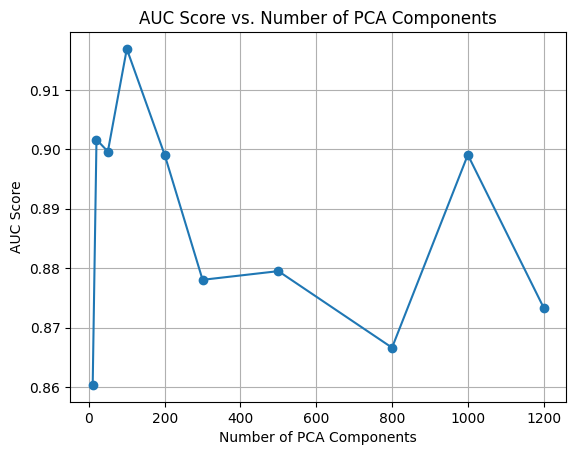

In [8]:
# Plot AUC scores against the number of PCA components
plt.plot(tpot_df["PCA Components"], tpot_df["AUC"], marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("AUC Score")
plt.title("AUC Score vs. Number of PCA Components")
plt.grid()
plt.show()